In [2]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import CelebA
from torch.utils.data import DataLoader
from torch import nn
import torch.optim as optim
from tqdm.auto import tqdm
import os
print(os.getcwd())

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/arp/Documents/github/ml-pytorch/practice


In [3]:
# Define image transformations
transform = transforms.Compose([transforms.Resize((128, 128)), transforms.ToTensor()])

# Load CelebA dataset
dataset = CelebA(
    root="../data", split="train", target_type="attr", transform=transform, download=True
)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

Files already downloaded and verified


In [5]:
class CelebAModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.linear_block = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 30 * 30, 128),
            nn.ReLU(),
            nn.Linear(128, 40)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.linear_block(x)
        return x

In [ ]:
model = CelebAModel()
print(model)

In [6]:
# Use BCEWithLogitsLoss for multi-label classification
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

model.to(device)
model.train()
# Training loop
for epoch in range(2):  # number of epochs
    running_loss = 0.0
    iteration = 0
    for index, (images, labels) in tqdm(enumerate(dataloader)):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels.to(torch.float))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if iteration == 500:
            break
        iteration += 1

    print(f"Epoch {epoch+1}, Loss: {running_loss/iteration*2*32}")

0it [00:00, ?it/s]

Epoch 1, Loss: 21.697153076171876


0it [00:00, ?it/s]

Epoch 2, Loss: 17.65160307121277


In [8]:
val_dataset = CelebA(root='../data', split='valid', target_type='attr', transform=transform, download=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Evaluation loop
model.eval()
model.to(device)
correct = 0
total = 0
with torch.inference_mode():
  iteration = 0
  for index, (images, labels) in tqdm(enumerate(val_dataloader)):
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    predicted = torch.sigmoid(outputs) > 0.5
    total += labels.size(0) * 40  # 40 attributes
    correct += (predicted == labels).sum().item()
      
    if iteration == 500:
        break
    iteration += 1

accuracy = correct / total
print(f"Accuracy: {accuracy * 100:.2f}%")

Files already downloaded and verified


  1%|          | 13.1M/1.44G [06:13<11:19:35, 35.1kB/s]
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7239f08ee750>>
Traceback (most recent call last):
  File "/home/arp/Documents/github/ml-pytorch/.direnv/python-3.12/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


0it [00:00, ?it/s]

Accuracy: 88.67%


In [7]:
from pathlib import Path
model_path = Path("../models")

In [9]:
# Save model
model_path.mkdir(parents=True, exist_ok=True)
torch.save(model.state_dict(), model_path / "celeb_model.pth")

torch.Size([3, 128, 128])


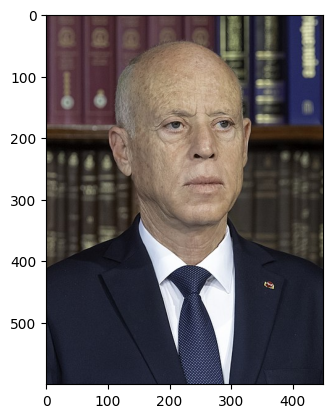

In [18]:
from PIL import Image
import matplotlib.pyplot as plt
loaded_model = CelebAModel()
loaded_model.load_state_dict(torch.load(model_path / "celeb_model.pth"))
loaded_model.to(device)
img = Image.open("./test/celeb/President_Kais_Saïed.jpg")
img_to_tensor = transform(img)
print(img_to_tensor.shape)
plt.imshow(img)

In [17]:

classnames = dataset.attr_names

y_preds = loaded_model(img_to_tensor.to(device).unsqueeze(0))
y_labels = torch.sigmoid(y_preds) > 0.25
print(y_labels.squeeze().shape)
for v in range(len(y_labels.squeeze())):
  if y_labels.squeeze()[v].item():
    print(classnames[v])

torch.Size([40])
Blurry
Eyeglasses
Male
No_Beard
